In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

In [19]:
df = pd.read_csv('GE.csv')
print(df.head()) #7 columns, including the Date. 

         Date       Open       High        Low      Close  Adj Close    Volume
0  2023-04-25  81.364723  81.412613  77.853149  78.563446  78.219177  11649768
1  2023-04-26  78.395851  78.571426  76.687950  76.783722  76.447243   8032357
2  2023-04-27  77.430168  78.363930  77.094971  78.260178  77.917236   9348633
3  2023-04-28  77.517960  79.584999  77.318436  78.986435  78.640305   6279159
4  2023-05-01  79.401436  81.404633  79.305664  80.750198  80.396347   7408237


In [20]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

237   2024-04-04
238   2024-04-05
239   2024-04-08
240   2024-04-09
241   2024-04-10
242   2024-04-11
243   2024-04-12
244   2024-04-15
245   2024-04-16
246   2024-04-17
247   2024-04-18
248   2024-04-19
249   2024-04-22
250   2024-04-23
251   2024-04-24
Name: Date, dtype: datetime64[ns]
['Open', 'High', 'Low', 'Close', 'Adj Close']


In [21]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)


In [22]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [23]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [24]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (238, 14, 5).
trainY shape == (238, 1).


In [25]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
14/14 [==============================] - 5s 53ms/step - loss: 0.2162 - val_loss: 6.2734
Epoch 2/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0728 - val_loss: 2.8333
Epoch 3/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0458 - val_loss: 5.9942
Epoch 4/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0367 - val_loss: 3.2776
Epoch 5/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0309 - val_loss: 0.8791
Epoch 6/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0255 - val_loss: 2.4144
Epoch 7/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0326 - val_loss: 0.1557
Epoch 8/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0223 - val_loss: 0.4510
Epoch 9/10
14/14 [==============================] - 0s 18ms/step - loss: 0.0219 - val_loss: 0.2041
Epoch 10/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0288 - val_loss: 0.1574


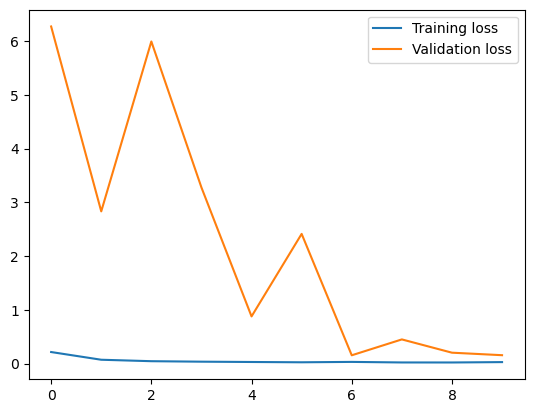

In [26]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [31]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

[Timestamp('2024-04-03 00:00:00'), Timestamp('2024-04-04 00:00:00'), Timestamp('2024-04-05 00:00:00'), Timestamp('2024-04-08 00:00:00'), Timestamp('2024-04-09 00:00:00'), Timestamp('2024-04-10 00:00:00'), Timestamp('2024-04-11 00:00:00'), Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00'), Timestamp('2024-04-16 00:00:00'), Timestamp('2024-04-17 00:00:00'), Timestamp('2024-04-18 00:00:00'), Timestamp('2024-04-19 00:00:00'), Timestamp('2024-04-22 00:00:00'), Timestamp('2024-04-23 00:00:00')]
1/1 [==============================] - 0s 34ms/step


In [32]:
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


1/1 [==============================] - 0s 40ms/step


C:\Program Files\KMSpico\temp\ipykernel_18044\586102767.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])
C:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:

<Axes: xlabel='Date', ylabel='Open'>

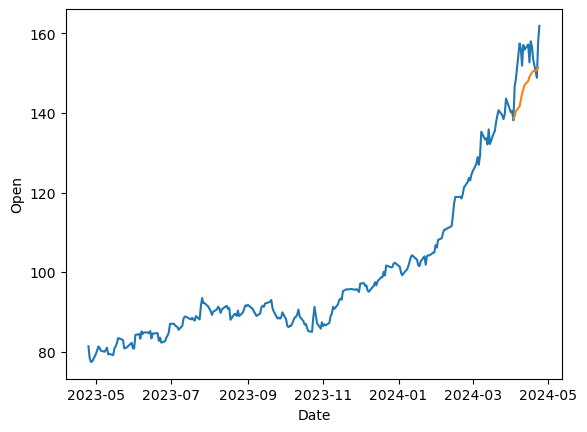

In [34]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
  forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'Open': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-05-01']  # Ensures consistent date format

# Create line plots using keyword arguments
sns.lineplot(x="Date", y="Open", data=original)  # Plot for original data
sns.lineplot(x="Date", y="Open", data=df_forecast)  # Plot for forecast data